# Segmentació

Fins ara tant a teoria com a les anteriors sessions de pràctiques hem vist com emprar models de segmentació i detecció amb *datasets* ja preparats. Però com feim la tasca de crear les màscares pel *ground truth* és una tasca que no hem vist fins ara. A la sessió d'aquesta setmana combinarem aquesta feina amb l'ús de la xarxa YOLO, emprant les versions d'[Ultralytics](https://docs.ultralytics.com/)

En aquesta pràctica, aprendrem a utilitzar [*Label Studio*](https://labelstud.io/guide), una eina versàtil i de codi obert que facilita l'etiquetatge de dades per a projectes d'aprenentatge automàtic. L'objectiu principal serà comprendre com podem generar ground truth (GT) per a tasques de segmentació i detecció d'objectes, un pas crític per entrenar models precisos i robustos.

Durant la sessió:

1. Definirem etiquetes i esquemes: Establirem les categories d'objectes i regles per a la segmentació o detecció.
2. Practicarem amb etiquetatge manual: Crearem etiquetes manualment, identificant regions o delimitant objectes dins d'un conjunt d'imatges.
3. Exportarem les etiquetes generades: Coneixerem com exportar el ground truth en formats compatibles amb llibreries com ``PyTorch`` o ``Ultralythics``.

Aquesta pràctica ens ajudarà a entendre millor el procés d'etiquetatge i a generar dades de qualitat per a experiments en segmentació semàntica o detecció d'objectes.

**NOTA:** Farem la generació del GT en local

## *Label Studio*.

**Instal·lació**

```
pip install label-studio
```

**Execució**

```
label-studio start
```

Una vegada iniciat haureu de crear un compte de l'aplicació.

**GUI**

![](screen.png)


**Ens hi posam**

**NOTA**:


| Info            | Enllaços                                                                     |
|-----------------|------------------------------------------------------------------------------|
| Codi per classe | [Enllaç](https://gist.github.com/rcland12/dc48e1963268ff98c8b2c4543e7a9be8)  |
| Format COCO8    | [Enllaç](https://docs.ultralytics.com/es/datasets/detect/coco8/#introduction) |


## Segmentació

Emprarem exhaustivament la llibreria d'Ultralytics. Per instal·lar-la:

```
pip install ultralytics
```

Una vega obtenim el conjunt de dades podem emprar-ho per fer dues tasques diferents: predicció i entrenament. En ambdues tasques l'ús de mètriques és fonamental, ja sigui per emprar-ho com a funció de pèrdua o bé com a mesura de qualitat.

A part de les mètriques que ja coneixeu (IOU i Dice coefficient per segmentació) existeix una funció àmpliament emprada per mesurar la qualitat d'aquest tipus de models: la **mAP**. Tot seguit teniu una explicació generada per ChatGPT i revisada per un humà:

La mAP (mean Average Precision) és una mètrica àmpliament utilitzada per avaluar el rendiment en tasques de segmentació, especialment en problemes on cal detectar i delimitar objectes dins d'una imatge. Aquesta mètrica combina la precisió i la recuperació per calcular l'eficiència del model a l'hora de predir regions segmentades correctament.

En segmentació, la mAP es calcula com la mitjana de les AP (Average Precision) per a diferents classes o nivells de superposició. Per a una sola classe, l'AP es deriva d'una corba de precisió-recall: es mesura la precisió mitjana en diferents llindars de confiança o de superposició, com l'IoU (Intersection over Union). L'IoU quantifica la superposició entre la màscara predita i la màscara real. Llindars comuns són 0.5 (coincidència moderada) o valors més alts per coincidències més estrictes.

A la pràctica, la mAP per segmentació sol incloure aquests passos:

- Calcul de l'IoU entre màscares predites i màscares reals.
- Associar prediccions correctes a les reals segons un llindar d'IoU establert.
- Generar la corba de precisió-recall.
- Obtenir l'AP per classe i, finalment, la mitjana de totes les classes per obtenir la mAP.


Una implementació de mAP extreta d'aquest [repositori](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/metrics/mean_avg_precision.py)

In [1]:
import torch
from collections import Counter

epsilon = 1e-9

def intersection_over_union(outputs, labels):
    outputs = outputs.squeeze(1)  # B x 1 x H x W => B x H x W

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + epsilon) / (union + epsilon)

    return iou


def mean_average_precision(
        pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_iou = 0
            best_gt_idx = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


image 1/1 C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\17_Segmentaci_desde_zero\images\8ff1865e-Cats_Test13.png: 448x640 1 car, 1 dog, 57.5ms
Speed: 2.0ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


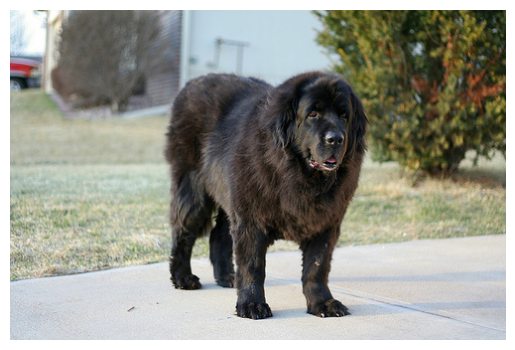

In [6]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11n.pt")

# Define path to the image file
source = "images/8ff1865e-Cats_Test13.png"

# Run inference on the source
results = model(source)  # list of Results objects

# Load the image
image = cv2.imread(source)

# Iterate over the results and draw bounding boxes
for result in results[0].boxes.xyxy:
    rectangle = result.numpy().astype(int)  # Convert to integers
    # Draw the rectangle using the correct coordinates
    cv2.rectangle(image, (rectangle[0], rectangle[1]), (rectangle[2], rectangle[3]), (0, 255, 0), 2)

# Display the image with all bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axes
plt.show()

## Tasques a fer (si hi ha temps)

1. Descarregar el conjunt de dades de [Cans Vs Moixos](https://www.kaggle.com/c/dogs-vs-cats/overview) de Kaggle i segmenta una part d'aquestes imatges.
2. Fer inferència emprant [YOLOv5](https://docs.ultralytics.com/modes/predict/#key-features-of-predict-mode).
3. Obté l'*mAP* de les imatges.
4. Fer un procés de *fine-tunning* emprant [YOLOv5](https://docs.ultralytics.com/modes/train/) amb les dades emprades.
5. Obté l'*mAP* de les imatges.

